<a href="https://colab.research.google.com/github/passaH2O/notebooks/blob/main/GeoFlood_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GeoFlood demo Jupyter notebook**

**Save a copy of this notebook on Drive**

 - Before you do anything, go to File > Save copy in Drive so you can keep and work on your own copy.*

**Purpose of this notebook**
 - Perform all operations in the GeoFlood workflow to obtain flood inundation extent and depth based on a hydrological forecast of discharge.

<sub>*This notebook is intended to be run on Google Colab, but can be run locally with some minor modifications.

---
# **(1) Prepare the GeoFlood software environment in Google Colab**
 - Install GRASS GIS and GDAL
 - Clone GeoFlood and TauDEM GitHub repositories
 - Download necessary python libraries
 - Allow ~10 minutes to for this cell to run

In [ ]:
%%capture
%%bash

# add ppas for latest package versions
sudo add-apt-repository --yes ppa:ubuntugis/ppa 
sudo add-apt-repository --yes ppa:ubuntu-toolchain-r/test
sudo apt update && sudo apt-get upgrade --yes

# download and install GRASS GIS and GDAL
sudo apt install --yes --fix-missing libproj-dev proj-data proj-bin \
                 libgeos-dev unzip subversion grass grass-dev \
                 libcanberra-gtk-module python3-distutils \
                 libhdf5-serial-dev netcdf-bin libnetcdf-dev libnetcdff-dev

# download and install geoflood
git clone https://github.com/passaH2O/GeoFlood.git

# install GDAL separately because it needs special arguments to setup correctly
pip install \
  --global-option=build_ext \
  --global-option="-I/usr/include/gdal" \
  GDAL==`gdal-config --version`

# write textfile with all the python libraries we will install
cat <<EOT >> geoflood_requirements.txt
numpy
scipy
pandas
matplotlib
ipykernel
rasterio==1.1.3
numba
netCDF4
statsmodels
proj
six
geopandas
EOT

# install GeoFlood python dependencies
pip install -r geoflood_requirements.txt

# download and install taudem
# NOTE: in this notebook, we use an experimental fork of TauDEM
git clone https://github.com/amoodie/TauDEM.git
cd TauDEM
git checkout amoodie-inunmap

# get colab's number of cores (probably 2)
export nproc=$(nproc)

# compile and build TauDEM
cd src
mkdir build
cd build
cmake ..
make -j $nproc && make install -j $nproc

 - add TauDEM executables to PATH environment variable

In [ ]:
import os
os.environ['PATH'] = '/usr/local/taudem:' + os.environ['PATH']

---
# **(2) Configuration of folders for storing and accessing inputs and outputs**
First run the cell below and follow the prompts to mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Make a folder in Google Drive called `geoflood_demo` to store input and output data for this demo notebook
2. Download example input data to `geoflood_demo`

In [ ]:
%%capture

!wget https://github.com/passaH2O/notebooks/raw/main/INPUT.tar.gz
!tar xzf INPUT.tar.gz INPUT 2> /dev/null
!find INPUT -name '.*' -type f -delete
%mkdir /content/drive/MyDrive/geoflood_demo
%mv INPUT /content/drive/MyDrive/geoflood_demo

This configuration script sets up the GeoFlood file structure in our `geoflood_demo` folder

In [ ]:
!python /content/GeoFlood/GeoNet/pygeonet_configure.py \
  -dir /content/drive/MyDrive/geoflood_demo \
  -p OnionCreek -n OC1mTest --no_chunk \
  --input_dir INPUT --output_dir OUTPUT


 
GeoNet and GeoFlood Home Directory for Inputs and Outputs Folder: 
/content/drive/MyDrive/geoflood_demo
Project Name: OnionCreek
DEM Name: OC1mTest
Not chunking input DEM or its products in Network Extraction script
Input Folder Name: INPUT
Output Folder Name: OUTPUT
Will attempt to use NHD HR Flowline binary raster in cost function if found in GIS Outputs.
Configuration Complete


---
# **(3) Run nonlinear filtering on a portion of Onion Creek**

In [ ]:
!python ./GeoFlood/GeoNet/pygeonet_nonlinear_filter.py

('reading geotiff', 'OC1mTest.tif')
507.078
-3.4028235e+38
Computing slope of raw DTM
DEM slope array shape: (3378, 4750)
Computing lambda = q-q-based nonlinear filtering threshold
('dem smoothing Quantile', 0.9)
('edgeThresholdValue:', 0.34356024861335754)
writing filtered DEM
('filtered DEM size:', '3378', 'rowsx', '4750', 'columns')
('time taken to complete nonlinear filtering:', 18.914942136000036, ' seconds')


---
# **(4) Compute flow directions and flow accumulation**
We are now going to use GRASS GIS functions to compute flow directions, flow accumulation, and identify subbasins within our domain based on this information. All these operations are contained within the script `pygeonet_grass_py3.py`. As usual, you can open it from your cloned repo on the left to have a look. 

In [ ]:
!python ./GeoFlood/GeoNet/pygeonet_grass_py3.py

Cleaning existing Grass location
Making the geonet location
Location <geonet> created
You can switch to the new location by
`g.mapset mapset=PERMANENT location=geonet`
Existing Mapsets after making locations:
Available mapsets:
Setting GRASSGIS environ
Making mapset now
Mapset switched. Your shell continues to use the history for the old mapset
You can switch the history by commands:
history -w; history -r /root/grassdata/geonet/geonetuser/.bash_history;
HISTFILE=/root/grassdata/geonet/geonetuser/.bash_history
List of installed extensions (modules):
Files to be removed:
         '-f' flag to force removal
WARNING: Extension <r.stream.basins> already installed. Re-installing...
Fetching <r.stream.basins> from
<https://svn.osgeo.org/grass/grass-addons/grass7> (be patient)...
Compiling...
Installing...
Updating private addons metadata file...
Installation of <r.stream.basins> successfully finished
Files to be removed:
         with '-f' flag to force removal
WARNING: Extension <r.strea

---
# **(5) Compute slope and geometric curvature on the filtered terrain**

We are now going to call as input our filtered landscape and we will compute the slope and geometric curvature, which is the default definition of curvature used in GeoNet and GeoFlood. All the operations are contained within `pygeonet_slope_curvature.py`. You can open the actual script by double clicking on it from the repository on the left.

In [ ]:
!python ./GeoFlood/GeoNet/pygeonet_slope_curvature.py

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
computing slope
 slope statistics
 angle min: 0.0
 angle max: 54.863846043721324
 mean slope: 0.13960592
 stdev slope: 0.15432632
('writing geotiff', 'OC1mTest_slope.tif')
computing curvature
nan
 using geometric curvature
 curvature statistics
 non-nan curvature cell number: 16045500
 non-nan finite curvature cell number:  mean:  -0.00031314598
 standard deviation:  0.112147875
('writing geotiff', 'OC1mTest_curvature.tif')
('time taken to complete slope and curvature calculation:', 2.8246432489997915, ' seconds')


---
# **(6) Compute skeletons based on curvature, flow accumulation, and curvature and flow accumulation combined**

We will now call a new operation in this notebook, which allows us to use curvature only, flow accumulation only, and curvature and flow accumulation combined to identify which parts of the landscape are likely channelized. All these operations are contained within `pygeonet_skeleton_definition.py`.

In [ ]:
!python ./GeoFlood/GeoNet/pygeonet_skeleton_definition.py

Curvature mean:  -0.00031413726
Curvature standard deviation:  0.11232527
DEM Projection: EPSG:6343
Mean upstream flow:  2710.079314624685
('writing geotiff', 'OC1mTest_curvatureskeleton.tif')
('writing geotiff', 'OC1mTest_flowskeleton.tif')
('writing geotiff', 'OC1mTest_skeleton.tif')
('time taken to complete skeleton definition:', 4.279738767000026, ' seconds')


---
# **(7) Identify end points of NHD MR channels**

We are going to now use `Network_Node_reading.py` to automatically identify the end points of the input flowline - the NHD MR information for this watershed. This operation is contained within the GeoFlood portion of the code and will generate a new output in the Output folder called `OC1mTest_endPoints`. This file contains the coordinates (start and end point) of the end points of each flowline. 

In [ ]:
!python ./GeoFlood/GeoFlood/Network_Node_Reading.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
   RiverID  ...         END_Y
0        1  ...  3.336201e+06

[1 rows x 5 columns]
('time taken to detect end points:', 0.1715027369998552, ' seconds')


---
# **(8) Network extraction with cost function including negative height**

We are now going to extract the geodesic curve between end points using the default cost function that includes negative height.  

**Compute negative height information**

We are going to use `Relative_Height_Estimation.py`, which will return a binary raster/array with values of 1 given to pixels at a lower elevation than the elevation associated with NHD MR Flowline pixels and a value of zero to all other pixels, i.e. pixels at a higher elevation than the NHD MR Flowlines. 

This operation will produce three more outputs; the `_NegaHand` is the relative height we are looking for to be added to the cost function, while the other two (`_nhdflowline` and `_Allocation`) are the rasterized NHD flowline used for calculation and another term used for identifying the corridor of values below the elevation the NHD.


In [ ]:
!python ./GeoFlood/GeoFlood/Relative_Height_Estimation.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
Time taken for Negative Height Calculation: 6.763646611000013 seconds


---
# **Network extraction with negative height**

We can now run our `Network_Extraction.py` to obtain the geodesic curve between the end points. 


In [ ]:
!python ./GeoFlood/GeoFlood/Network_Extraction.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
Chunk status: 0
./GeoFlood/GeoFlood/Network_Extraction.py:236: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(f'DEM Size: {round(np.float(dem_bytes)/10**9,3)} GB')
DEM Size: 0.064 GB
Not attempting to chunk DEM
Couldn't find HR raster. Calculating Cost without it.
Cost shape: (3378, 4750)
RAM usage before create path 0: svmem(total=13617737728, available=12042817536, percent=11.6, used=2235854848, free=4448944128, active=2743336960, inactive=5935779840, buffers=287420416, cached=6645518336, shared=1236992, slab=420745216)
 
[[2266, 1388]]
Number of endpoints: 1
(

---
# **(9) TauDEM preparation**
Let's assign our working directory to a variable to shorten the file paths in our TauDEM commands

In [ ]:
%env demo=/content/drive/MyDrive/geoflood_demo

env: demo=/content/drive/MyDrive/geoflood_demo


TauDEM can leverage a computer's resources by running parallel processes.
We see from the command below that Google Colab provides 2 processors, so we will run TauDEM operations with 2 processors

(pass an argument of 2 with the `-n` flag)

In [ ]:
!nproc

2


---
# **(10) TauDEM operations to prepare for the HAND raster calculation**

We will now compute the HAND raster. As it is based on Dinf flow directions, we will need to perform pit filling on the elevation data and compute flow directions.

---
 - **Pit filling**

In [ ]:
!mpiexec --allow-run-as-root -n 2 pitremove \
    -z $demo/INPUT/GIS/OnionCreek/OC1mTest.tif \
    -fel $demo/OUTPUT/GIS/OnionCreek/OC1mTest_fel.tif

PitRemove version 5.3.9
Input file /content/drive/MyDrive/geoflood_demo/INPUT/GIS/OnionCreek/OC1mTest.tif has projected coordinate system.
Nodata value input to create partition from file: -340282346638528859811704183484516925440.000000
Nodata value recast to float used in partition raster: -340282346638528859811704183484516925440.000000
This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
Processes: 2
Header read time: 0.261272
Data read time: 0.161832
Compute time: 14.786671
Write time: 1.610928
Total time: 16.820703


---
 - **Dinf flow directions**

In [ ]:
!mpiexec --allow-run-as-root -n 2 dinfflowdir \
    -fel $demo/OUTPUT/GIS/OnionCreek/OC1mTest_fel.tif \
    -ang $demo/OUTPUT/GIS/OnionCreek/OC1mTest_ang.tif \
    -slp $demo/OUTPUT/GIS/OnionCreek/OC1mTest_slp.tif

DinfFlowDir version 5.3.9
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_fel.tif has projected coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
This run may take on the order of 5 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
All slopes evaluated. 539517 flats to resolve.
Draining flats towards lower adjacent terrain
.........................................................................................................................................................................................................................................................

---
# **(11) HAND calculation with GeoFlood flowline**

We will now use the previous outputs from TauDEM to compute the HAND raster based on the GeoFlood flowline. 

In [ ]:
!mpiexec --allow-run-as-root -n 2 dinfdistdown \
    -ang $demo/OUTPUT/GIS/OnionCreek/OC1mTest_ang.tif \
    -fel $demo/OUTPUT/GIS/OnionCreek/OC1mTest_fel.tif \
    -slp $demo/OUTPUT/GIS/OnionCreek/OC1mTest_slp.tif \
    -src $demo/OUTPUT/GIS/OnionCreek/OC1mTest_path.tif \
    -dd $demo/OUTPUT/GIS/OnionCreek/OC1mTest_hand_GeoFlood.tif \
    -m ave v

DinfDistDown -v version 5.3.9
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_ang.tif has projected coordinate system.
This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
Nodata value input to create partition from file: -340282346638528859811704183484516925440.000000
Nodata value recast to float used in partition raster: -340282346638528859811704183484516925440.000000
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_fel.tif has projected coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
Input file /conte

---
# **(12) Calculation of hydraulic geometry for the stream reach**

Now that we have the HAND raster, we will go back to GeoFlood functions to compute the hydraulic geometry properties for this river reach, which will then be used to translate the discharge forecast into a depth prediction for inundation mapping (in the next lab).

The first operation we are going to perform is the segmentation of the flowline which is done within `Streamline_Segmentation.py`. This operation checks the length of the flowline; if the length is longer than a predefined maximum segment length, the script breaks the original flowline into equal-length segments with a length shorter than the predefined threshold. The input of this script is the extracted river network shapefile (`OC1mTest_channelNetwork.shp`), and the output is a river segment shapefile (`OC1mTest_channelSegment.shp`).



---

# **Channel segmentation**

In [ ]:
!python ./GeoFlood/GeoFlood/Streamline_Segmentation.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
('time taken to segment streamline:', 0.21153304499966907, ' seconds')




---
# **Catchment delineation**

Now we will delineate the catchment for the segmented flowline. Similarly to what we have done in the past, the script uses a GRASS function called from `Segment_Catchment_Delineation.py`.

The river segment shapefile (`OC1mTest_channelSegment.shp`) is one of the script inputs. Since this script relies on the GRASS GIS catchment delineation routine, the flow direction raster (`OC1mTest_fdr.tif`) we derived with GRASS is another input. The output of this script is a segment catchment geotiff file (`OC1mTest_segmentCatchment.tif`).

In [ ]:
!python ./GeoFlood/GeoFlood/Grass_Delineation_py3.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
Cleaning existing Grass location
Making the geonet location
Location <geonet> created
You can switch to the new location by
`g.mapset mapset=PERMANENT location=geonet`
Existing Mapsets after making locations:
Available mapsets:
Setting GRASSGIS environ
Making mapset now
Mapset switched. Your shell continues to use the history for the old mapset
You can switch the history by commands:
history -w; history -r /root/grassdata/geonet/geonetuser/.bash_history;
HISTFILE=/root/grassdata/geonet/geonetuser/.bash_history
List of installed extensions (modules):
Files to be removed:
         '-f' flag to force removal
WARNING: Extension <r.stream.basins> already installed. Re-installing...
Fetching <r.stream.basins> from
<https://svn.osgeo.org/grass/grass-addons/grass7> (be patient)...
Compiling...
Installing...
Updating private addons metadata file...
Installation of <r.stream.basins> successfully fin



---


# **Calculation of hydraulic geometry properties**

We can now use the segments, the delineated catchments, and the HAND raster to obtain the hydraulic geometry properties of each of these segments. We will start by running the GeoFlood script `River_Attribute_Estimation.py`, which is used to compute bed slope, river length, and catchment area. The inputs to this script are the DEM in the input folder, the river segments we have previously identified, and the segment catchment raster we just got from GRASS in our `OUTPUT` folder. This script will output a segment catchment polygon shapefile and a river attribute text file, which will be placed in the Hydraulics folder in your `OUTPUT/Hydraulics` folder.

You will find new outputs in your Outputs folder. In particular, in the GIS folder you will find the _segmentCatchment.shp and in the Hydraulics folder you will find the river attribute text file.

In [ ]:
!python ./GeoFlood/GeoFlood/River_Attribute_Estimation.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
Total Segments: 6
Segment: 1
./GeoFlood/GeoFlood/River_Attribute_Estimation.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m_array_du_np = np.asarray(m_array_du)
./GeoFlood/GeoFlood/River_Attribute_Estimation.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  z_array_du_np = np.asarray(z_array_du)
Segment: 2
Segment: 3
Segment: 4
Segment: 5
Segment: 6
('time taken to estimate river attributes:', 1.0324660989999757, ' seconds')


---
# **Associate channel roughness to segments**
We will now run the script `Network_Mapping.py` which takes the channel roughness information from the original river network and saves it in the segmented river network. The script takes as input the original catchment shapefile, which is the new input we just added as part of this lab (`Catchment.shp`) and the river segment shapefile we have created (`OC1mTest_channelSegment.shp`).

This script will create a new output in your `OUTPUT` GIS folder which has csv format and contains the COMID of each of the segments in our flowline.

In [ ]:
!python ./GeoFlood/GeoFlood/Network_Mapping.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
6
('time taken to map network:', 0.31207081499997, ' seconds')


---
# **Derivation of channel hydraulic properties**
The next script is part of TauDEM and is called CatchHydroGeo. This script is used to derive the channel hydraulic properties using the terrain analysis products. The inputs are the HAND raster we computed (`OC1mTest_HAND.tif`), the segment catchment raster (`OC1mTest_segmentCatchment.tif`), the Dinf slope raster (`OC1mTest_slp.tif`), the river attribute text file (`OC1mTest_River_Attribute.txt`) and the stage range text file we input.

Once the execution is finished, the resulting channel characteristic table with hydraulic properties directly derived from the HAND raster (`hydroprop-basetable.csv`) will be found in the `OUTPUT/Hydraulics` folder and contains the hydraulic geometry properties for each stage value we input.

In [ ]:
!mpiexec --allow-run-as-root -n 2 catchhydrogeo \
    -hand $demo/OUTPUT/GIS/OnionCreek/OC1mTest_hand_GeoFlood.tif \
    -catch $demo/OUTPUT/GIS/OnionCreek/OC1mTest_segmentCatchment.tif \
    -catchlist $demo/OUTPUT/Hydraulics/OnionCreek/OC1mTest_River_Attribute.txt \
    -slp $demo/OUTPUT/GIS/OnionCreek/OC1mTest_slp.tif \
    -h $demo/INPUT/Hydraulics/OnionCreek/stage.txt \
    -table $demo/OUTPUT/Hydraulics/OnionCreek/hydroprop-basetable.csv

CatchHydroGeo version 5.3.9
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_hand_GeoFlood.tif has projected coordinate system.
This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
Nodata value input to create partition from file: -340282346638528859811704183484516925440.000000
Nodata value recast to float used in partition raster: -340282346638528859811704183484516925440.000000
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_segmentCatchment.tif has projected coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int32_t used in partition raster: -32768
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek

---
# **Derivation of synthetic rating curves**
We have a final GeoFlood script to run, called `Hydraulic_Property_Postprocess.py`, which combines the channel roughness coefficient and the properties that we have obtained in the above steps to derive reach average geometric properties for the reach and synthetic rating curves. The inputs are the COMID-based Manning’s values (`COMID_Roughness.csv`), the network ID mapping csv table (`OC1mTest_networkMapping.csv`), and the base geometric properties (`hydroprop-basetable.csv`).

You will find as output the full channel properties table with synthetic rating curves in the `OUTPUT` Hydraulics folder, called `hydroprop-fulltable.csv`.

In [ ]:
!python ./GeoFlood/GeoFlood/Hydraulic_Property_Postprocess.py

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
('time taken to postprocess hydraulic properties:', 0.11273209799992401, ' seconds')


# **(13) Estimation of flood inundation extent and depth**

And finally, what we were all waiting for! We will integrate all the results above to estimate flood inundation extent and depth based on the hydrological prediction provided as input which comes from the National Water Model. 

https://water.noaa.gov/about/nwm

---
# **Assign NWM input forecasted discharge to channel segments**

This first operation takes the NWM forecast that we provided in input and will assign it to each channel segment based on COMID. The script performs the discharge-stage conversion based on the NWM netCDF output (general format: `nwm.txxz.product_type.channel_rt.fxxx.conus.nc`) from the NWM input folder. The script also uses the network id mapping table, which records how the COMIDs are linked to the ids of the extracted river segments. The script also uses the full channel property table, which contains stage-discharge data pairs for each segment used in stage height interpolation. 

The script produces the depth corresponding to the discharge for each segment in both netCDF and CSV formats. The depths files have the same file name as the NWM inputs and they will be stored in the corresponding OUPUT NWM folder. 

Since our stream does not flood very often we are going to overwrite the discharge forecast so that we can make this system flood. 

<mark>**Modify forecasted discharge in Foreast_Table.py**</mark>

Open `Forecast_Table.py` from the left menu - the script is stored within the GeoFlood folder. Double click on the name of the script and uncomment line 63 by removing the symbol `#`. As you can see we are imposing a discharge of 500 to obtain a flood inundation map (do not worry about any of the symbols that are written on that same line after 500). 


In [ ]:
!python ./GeoFlood/GeoFlood/Forecast_Table.py \
    $demo/INPUT/NWM/OnionCreek/nwm.t00z.analysis_assim.channel_rt.tm01.conus.nc

Using configuration settings here: /content/drive/MyDrive/geoflood_demo/GeoFlood_OnionCreek.cfg
Forecast Complete




---
# **Compute flood inundation map corresponding to the forecasted discharge**

We will now quantify the flood extent and depth by using TauDEM's InunMap. 


In [ ]:
!mpiexec --allow-run-as-root -n 2 inunmap \
         -hand $demo/OUTPUT/GIS/OnionCreek/OC1mTest_hand_GeoFlood.tif \
         -catch $demo/OUTPUT/GIS/OnionCreek/OC1mTest_segmentCatchment.tif \
         -forecast $demo/OUTPUT/NWM/OnionCreek/nwm.t00z.analysis_assim.channel_rt.tm01.conus.nc \
         -mapfile $demo/OUTPUT/Inundation/OnionCreek/OC1mTest_NWM_inunmap.tif

InunMap version 5.3.9
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_hand_GeoFlood.tif has projected coordinate system.
This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
Nodata value input to create partition from file: -340282346638528859811704183484516925440.000000
Nodata value recast to float used in partition raster: -340282346638528859811704183484516925440.000000
Input file /content/drive/MyDrive/geoflood_demo/OUTPUT/GIS/OnionCreek/OC1mTest_segmentCatchment.tif has projected coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int32_t used in partition raster: -32768
Forecast input: /content/drive/MyDrive/geoflood_demo/OUTPUT/NWM/OnionCreek/

# **(14) Plot the inundation map!**

We can now have a look at the results here and check our inundation map. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.plot

In [ ]:
# open the HAND raster
demo_dir = '/content/drive/MyDrive/geoflood_demo'
with rasterio.open(f'{demo_dir}/OUTPUT/GIS/OnionCreek/OC1mTest_hand_GeoFlood.tif') as src:
    oc_hand_image = src.read(1) # read band 1 into a numpy array

# open the inundation raster
with rasterio.open(f'{demo_dir}/OUTPUT/Inundation/OnionCreek/OC1mTest_NWM_inunmap.tif') as src:
    oc_inun_image = src.read(1) # read band 1 into a numpy array

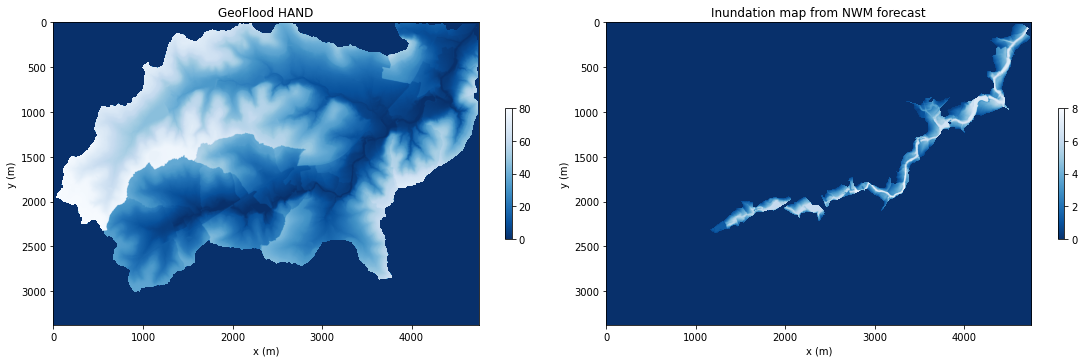

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

hand_im = ax[0].imshow(oc_hand_image, cmap='Blues_r', vmin=0, vmax=80)
fig.colorbar(hand_im, ax=ax[0], shrink=0.4)
ax[0].set_title("GeoFlood HAND")
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')

inun_im = ax[1].imshow(oc_inun_image, cmap='Blues_r', vmin=0, vmax=8)
fig.colorbar(inun_im, ax=ax[1], shrink=0.4)
ax[1].set_title("Inundation map from NWM forecast")
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('y (m)')

fig.tight_layout()

fig.show()